# HW5: Simultaneous Localization & Mapping (SLAM)

## EECE 5550: Mobile Robotics (Spring 2025)

**Collaboration Statement:**

In [ ]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.
# I completed the assignment by myself

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [1]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

# !pip install --upgrade --force-reinstall git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-ji5c7_1k
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-ji5c7_1k
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 150bea281e6fd35ba56f2a5c1ace6a0e6eba3063
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install gtsam

In [ ]:
# !pip install --upgrade numpy==1.26.4

Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [4]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable, Optional
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
from gym_neu_racing.sensor_models.sensor_model import SensorModel
from typing import Iterable, Optional
import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam import Marginals, Point2, Point3, Pose2, Pose3, Values
from gtsam.symbol_shorthand import L, X
from matplotlib import patches
from scipy.linalg import expm

# Problem 1: Point Cloud Registration with ICP

You'll impelement the iterative closest point (ICP) algorithm in this problem. You will be given two pointclouds, `X, Y`, which contain points in $R^n$, and an initial guess of the transformation, in the form of a translation vector `t` $\in R^n$ and rotation matrix `R` $\in SO(n)$. You should write your code so it can handle both $n=2$ and $n=3$ seamlessly. And `X` and `Y` may not contain the same number of points!

This algorithm will be important for doing Lidar Odometry & SLAM in Problem 2 below, where you'll run ICP between pointclouds from the lidar sensor as the robot moves around the environment.

## 1a) Estimate correspondences, given a guess of the transformation

Recall that ICP begins with an initial guess of the transformation between two pointclouds.

To be able to use Horn's method to improve that initial guess, we need to know which points in X correspond to points in Y. In ICP, we'll use the current guess of the transformation to help estimate these correspondences. These correspondences likely won't all be correct, but they will hopefully at least be good enough to improve the transformation estimate, which could lead to better correspondences in the next iteration.

In this part, you should implement `estimate_correspondences` to return a list of tuples that represent correspondences. That is, let each element `(i,j)` of C denote that after transforming the `i`th element from X by `R` and `t`, the closest point in Y has index `j`, and that closest point is within `d_max` ($l_2$ distance). Think about what happens if you make `d_max` too big or small -- it's an important parameter!

You are encouraged to make this calculation reasonably efficient, because ICP will call this at each iteration, and your SLAM code will call ICP many times! For example, an initial implementation that loops through every pair in X and Y may give the right answer but could be made much much faster by vectorizing the code and/or using numpy operations, such as `np.argmin` and `np.linalg.norm`.

**Devlierables**:
- Implement `estimate_correspondences` below to take in the two pointclouds `X, Y` and an estimated transformation, `R, t`, and output a list of correspondences, `C`

In [30]:
class ICP:
    def __init__(self, d_max=10, num_iterations=100, epsilon=1e-4):
        self.d_max = d_max
        self.num_iterations = num_iterations
        self.epsilon = 1e-4

    def run(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        t0: np.ndarray,
        R0: np.ndarray,
        plot_every=np.inf,
        show=False,
        pause=False,
        verbose=False,
    ) -> tuple[np.ndarray, np.ndarray]:
        # estimate t,R s.t. ||Y - (R @ x + t)|| is minimized
        # --> rotate x so it looks like y
        rmse = np.inf
        t, R = t0, R0
        i = 1
        while rmse > self.epsilon and i <= self.num_iterations:
            C = self.estimate_correspondences(X, Y, t, R)
            t, R = self.compute_optimal_rigid_registration(X, Y, C)
            rmse = RMSE(X, Y, C, t, R)
            # print(f'RMSE {i}: {rmse}')
            i += 1
        # raise NotImplementedError

        # C = self.estimate_correspondences(X, Y, t0, R0)
        # t, R = self.compute_optimal_rigid_registration(X, Y, C)
        
        return t, R

    def estimate_correspondences(self, X: np.ndarray, Y: np.ndarray, t: np.ndarray, R: np.ndarray) -> list[tuple[int, int]]:
        # C is a list of tuples.
        # If index i in Rx+t has closest point in Y with index j (and within
        # d_max), then add (i,j) to C.
        C = []

        Xt = (R @ X.T).T + t

        # # Loop
        # for i, x in enumerate(Xt):
        #     min_dist = np.inf
        #     min_j = -1
        #     for j, y in enumerate(Y):
        #         dist = np.linalg.norm(x - y)
        #         if dist < min_dist:
        #             min_dist = dist
        #             min_j = j
        #     if min_dist < self.d_max:
        #         C.append((i, min_j))

        # Vectorized
        dists = np.linalg.norm(Xt[:, None, :] - Y[None, :, :], axis=2)
        min_index = np.argmin(dists, axis=1)
        min_dists = np.min(dists, axis=1)
        valid_pairs = np.where(min_dists < self.d_max)[0]
        C = [(i, min_index[i]) for i in valid_pairs]

        # raise NotImplementedError

        return C

    def compute_optimal_rigid_registration(self, X: np.ndarray, Y: np.ndarray, C: list) -> tuple[np.ndarray, np.ndarray]:
        # Horn's method from lecture to get t, R from X, Y, C

        xf = np.array([X[i] for i, _ in C])
        yf = np.array([Y[j] for _, j in C])
        
        Xcentroid = np.mean(xf, axis=0)
        Xvectors = xf - Xcentroid
        Ycentroid = np.mean(yf, axis=0)
        Yvectors = yf - Ycentroid


        W = Yvectors.T @ Xvectors
        U, sig, Vt = np.linalg.svd(W)

        S = np.eye(U.shape[1])
        S[-1, -1] = np.linalg.det(U @ Vt)

        R = U @ S @ Vt
        t = Ycentroid - R @ Xcentroid

        # print(f'R: {R}')
        # print(f't: {t}')
        # raise NotImplementedError

        return t, R

def RMSE(X: np.ndarray, Y: np.ndarray, C: list[tuple[int, int]], t: np.ndarray, R: np.ndarray) -> float:
    # Of the corresponding points, calculate root mean square error btwn
    # Y and the transformed X
    X_transform = (R @ X.T).T + t
    
    X_final = np.array([X_transform[i] for i, _ in C])
    Y_final = np.array([Y[j] for _, j in C])

    rmse = np.sqrt(np.mean(np.linalg.norm(X_final - Y_final, axis=1) ** 2))
    # raise NotImplementedError

    return rmse

## 1b) Compute the optimal transformation, given a guess of the correspondences

Now that you have a guess of the correspondences, you can calculate the optimal (w.r.t. those possibly incorrect correspondences) rigid transformation between the two pointclouds using Horn's method.

**Deliverables:**
- Implement `compute_optimal_rigid_registration` above, which takes in the two pointclouds `X, Y` and correspondences `C`, and outputs the translation vector and rotation matrix, `t, R`

## 1c) Calculate the RMSE of the current transformation estimate

You need a way to estimate how good the current transformation estimate is, to determine if your algorithm has converged to a local minimum. In this part, you should calculate the root mean square error (RMSE) between the transformed pointcloud X and the pointcloud Y, *among the corresponding pairs of points*.

**Deliverables**:
- Implement `RMSE` above, which takes in the pointcouds `X, Y`, correspondences `C`, and transformation `t, R`, and outputs the RMSE (scalar). Note that this is a function outside of the `ICP` class (no `self` argument).

## 1d) Iterate between estimating the corresponences and transformation, until convergence

To complete the ICP implementation, simply iterate between the two methods you just implemented. You should add two termination conditions: terminate after a maximum number of iterations, or if the RMSE between successive iterations has not decreased by at least $\epsilon$.

**Deliverables**:
- Implement `run` above, which takes in the pointclouds `X, Y`, an initial guess of the transformation, `t0, R0`, and outputs a final transformation `t, R`. This method calculates the `t, R` to minimize the error between $Y$ and the transformed pointcloud, $RX+t$.
- Provide a plot of the two pointclouds at the beginning and end of the iterations
- Get familiar with what happens if the initial guess is not very good, and how the various parameters affect your result (this is not a deliverable per se, but having this intuition will help a lot in Problem 2)

To see if your ICP is working, you can use the following code. Here are some plotting utilities, you're welcome to modify or re-write:

In [31]:
def plot3D(X, Y, t, R, C=None, show=True, pause=False):
    ax = plt.gca()
    plt.cla()
    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c="b", marker=".")
    Xrot = np.dot(R, X.T).T + t
    ax.scatter(Xrot[:, 0], Xrot[:, 1], Xrot[:, 2], c="r", marker=".")
    plt.axis("equal")
    if show:
        plt.show()
    elif pause:
        plt.pause(pause)


def plot2D(X, Y, t, R, C=None, show=True, pause=False):
    ax = plt.gca()
    plt.cla()

    # show the ptcloud Y and the transformed X (using R, t)
    ax.scatter(Y[:, 0], Y[:, 1], c="b", marker=".")
    Xrot = np.dot(R, X.T).T + t
    ax.scatter(Xrot[:, 0], Xrot[:, 1], c="r", marker=".")

    # show a line between correspondences, if provided
    if C is not None:
        for c in C:
            x = Xrot[c[0]]
            y = Y[c[1]]
            ax.plot([x[0], y[0]], [x[1], y[1]], "k-")
    plt.axis("equal")

    if show:
        plt.show()
    elif pause:
        plt.pause(pause)


def plot(X, Y, t, R, C=None, show=True, pause=False):
    d = X.shape[1]
    if d == 2:
        plot2D(X, Y, t, R, C=C, show=show, pause=pause)
    elif d == 3:
        plot3D(X, Y, t, R, C=C, show=show, pause=pause)

Download the two 2D pointclouds [from here](https://northeastern-my.sharepoint.com/:f:/g/personal/m_everett_northeastern_edu/EqPcPbQGbH9Ltb5jzdKeKiIBqBkvQfIsxgThTliRFMI79w?e=JNO08h) and upload them to Colab or update the paths below if working locally.

Here is a block to load two pointclouds from .txt files, give an initial guess, and run ICP using parameters you can adjust:

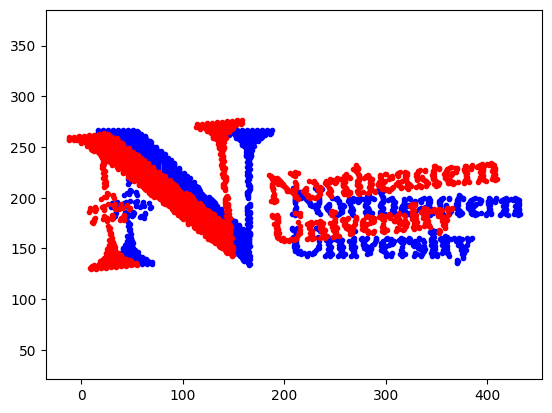

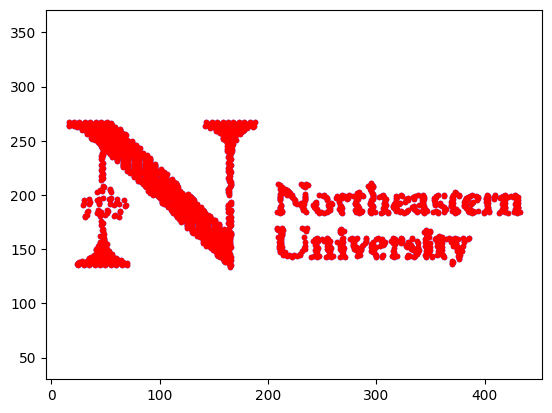

t=array([-255.97210046,  435.17615259])
R=array([[ 0.62160997,  0.78332691],
       [-0.78332691,  0.62160997]])


In [32]:
# 2d example
d = 2

# load pointclouds from file, and downsample to only load every n-th pt
# --> feel free to increase 5 to a larger number to get a sparser pointcloud
# while you're tuning! That should make ICP and plotting much faster.
X = np.loadtxt("data/logo_pcl2dX.txt", usecols=range(d))[::5]
Y = np.loadtxt("data/logo_pcl2dY.txt", usecols=range(d))[::5]

# initial guess
theta = -0.8
t0 = np.array([-300, 400])
R0 = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

# run ICP (adjust the parameters as needed!)
d_max = 10
num_iterations = 50
registrar = ICP(d_max=d_max, num_iterations=num_iterations)
t, R = registrar.run(X, Y, t0, R0, plot_every=1, show=True)

# rmse = np.inf
# rmse_diff = np.inf
# t, R = t0, R0
# plot2D(X, Y, t0, R0, show=True)
# i=0
# while rmse_diff > registrar.epsilon:
#     C = registrar.estimate_correspondences(X, Y, t, R)
#     t, R = registrar.run(X, Y, t, R, plot_every=1, show=True)
#     rmse_current = RMSE(X, Y, C, t, R)
#     rmse_diff = abs(rmse - rmse_current)
#     rmse = rmse_current
#     print(f"RMSE {i}: {rmse}")
#     # plot2D(X, Y, t, R, C=C, show=True)
#     i += 1
plot2D(X, Y, t0, R0, show=True)
plot2D(X, Y, t, R, show=True)
print(f"{t=}")
print(f"{R=}")
plt.show()

If you want to try this with other pointclouds from your own images for fun, we provide some code in the Appendix of this notebook.

# Problem 2: Lidar SLAM with Factor Graphs and ICP

In the previous assignment, you were given either the robot's true state *or* the true map. In this problem, you'll implement a basic version of SLAM, where you only have access to the robot's control inputs and measurements (not the true state or map).

The setup is as follows:
- The robot will start at some initial state and follow along a pre-defined trajectory to explore the environment. No need to worry about the planner, unless you want to do the extra credit at the very end (**2e**).
- The robot uses a Unicycle motion model and has a lidar sensor and a noisy wheel speed sensor. If you just accumulate the noisy wheel speed measurements according to the motion model, you may get a mildly useful map for small noise magnitudes but the map will become a smeared mess for larger noise magnitudes (**2b**).
- You can use your ICP implementation above to improve the estimate from purely accumulating the odometry. You will do this by adding relative pose factors between successive timesteps, which should improve the results by a lot (**2c**). To get a globally consistent map, you should also add some loop closures, which can be done in this assignment by hard-coding pairs of timesteps at which to run an additional round of ICP (**2d**).
- The environment is 10x10m and has walls all around the perimeter.
- You should do all of your estimation in the robot's initial body coordinate frame. That is, your initial pose estimate will be $(x, y, \theta) = (0, 0, 0)$ and subsequent poses/maps will be calculated relative to that. Meanwhile, the simulator will express the robot's true state in its own world frame (e.g., `env.unwrapped.state` will be `np.array([0.5, -3.5, np.pi / 2])`). To account for this static transform and make your visualizations more intuitive, we apply the initial pose transformation for you when rendering the map. Feel free to undo this if it's confusing (pass `initial_state=None` when `compute_map` is called below).

## Helper Functions / Background

Building a SLAM system turns out to require a decent amount of code. To let you focus on the factor graph components, we provide a handful of helper functions you can use, ignore, or re-write as needed.

We defined a simple open-loop control policy that will send the robot in a path around the environment to get reasonably good viewpoints with a few opportunities for loop closures. This policy hard-coded to this environment and initial state, which is not great practice but will let you tune your SLAM algorithm in a repeatable way. You should be able to make a good (albeit not 100% complete) map using this policy. For extra credit, you will have a chance to add a closed-loop policy that actively explores the environment as quickly as possible.

In [33]:
class OpenLoopPolicy:
    def __init__(self):
        self.actions = [
            (4., np.array([1.0, 0.0])),
            (5., np.array([0.5, -np.pi / 2])),
            (8., np.array([1.0, 0.0])),
            (9., np.array([0.5, -np.pi / 2])),
            (14., np.array([1.0, 0.0])),
            (15., np.array([0.5, -np.pi / 2])),
            (19.5, np.array([1.0, 0.0])),
            (20.5, np.array([0.5, -np.pi / 2])),
            (28.5, np.array([1.0, 0.0])),
            (29.5, np.array([0.5, np.pi / 2])),
            (32., np.array([1.0, 0.0])),
            (33., np.array([0.5, np.pi / 2])),
            (50., np.array([1.0, 0.0])),
        ]
        self.current_action_index = 0

    def get_action(self, t: float) -> np.ndarray:
        # Command the speed in the 2nd element until time exceeds 1st element,
        # then move to the next row in self.actions
        current_action = self.actions[self.current_action_index]
        if t > current_action[0]:
            self.current_action_index += 1
        action_twist = current_action[1]
        return action_twist

Your LidarOdometry will estimate the robot's pose at each timestep. To turn that into a map of the environment, you can use my `Mapper` implementation from the last assignment. The `compute_mapper` function will take in the list of past lidar measurements and estimated robot poses, and generates a map of the environment. If you have a better/faster way of going from measurements and estimated poses to a map, feel free to use that instead! This code runs pretty fast for short trajectories but will take a second or so to generate a map once the trajectory gets above ~100 steps.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from gym_neu_racing.envs.map import Map
from skimage.draw import line


def log_odds_to_prob(log_odds):
    return 1 - 1 / (1 + np.exp(log_odds))


def prob_to_log_odds(prob):
    return np.log(prob / (1 - prob))


class Mapper:
    def __init__(
        self,
        p_free: float = 0.2,
        p_occ: float = 0.8,
        p_prior: float = 0.5,
        x_width=10,
        y_width=10,
        grid_cell_size=0.1,
    ):
        self.map = Map(
            x_width=x_width, y_width=y_width, grid_cell_size=grid_cell_size
        )

        self.p_free = p_free
        self.p_occ = p_occ
        self.p_prior = p_prior
        self.log_odds_free = prob_to_log_odds(p_free)
        self.log_odds_occ = prob_to_log_odds(p_occ)
        self.log_odds_prior = prob_to_log_odds(p_prior)

        # initialize with P(occ) = 0.5 for all cells (unknown)
        self.map.log_odds_map = np.zeros(
            self.map.static_map.shape, dtype=float
        )

    @property
    def probability_map(self):
        return log_odds_to_prob(self.map.log_odds_map)

    def step(self, obs):
        """Using current state & lidar, update esimated gridmap log-odds."""

        # Use angles/ranges to get the (x, y) coordinates in the lidar frame, but
        # skip any pts where the range = np.inf
        ranges = obs["lidar"]["ranges"]
        non_max_range_inds = np.where(ranges < np.inf)
        ranges = ranges[non_max_range_inds]
        angles = obs["lidar"]["angles"][non_max_range_inds]
        hit_pts_in_lidar_frame = np.stack(
            [ranges * np.cos(angles), ranges * np.sin(angles)]
        ).T

        # Build the lidar-to-world TF matrix using the robot's current position, heading
        x, y, theta = obs["state"]
        T_world_lidar = np.array(
            [
                [np.cos(theta), -np.sin(theta), x],
                [np.sin(theta), np.cos(theta), y],
                [0, 0, 1],
            ]
        )

        # Transform the (x,y) coordinates from the lidar frame to the world frame
        hit_pts_in_lidar_frame_homogeneous = np.hstack(
            [
                hit_pts_in_lidar_frame,
                np.ones((hit_pts_in_lidar_frame.shape[0], 1)),
            ]
        )
        hit_pts_in_world_frame = np.dot(
            hit_pts_in_lidar_frame_homogeneous, T_world_lidar.T
        )[:, :2]

        hit_pts_in_map_inds, in_map = (
            self.map.world_coordinates_to_map_indices(hit_pts_in_world_frame)
        )
        # *** questionable logic *** ignore any lidar beams that end outside the map
        # --> should probably include the pts within the map...
        hit_pts_in_map_inds = hit_pts_in_map_inds[in_map == True]
        robot_pos_in_map_inds, in_map = (
            self.map.world_coordinates_to_map_indices(obs["state"][:2])
        )

        for hit_pt in hit_pts_in_map_inds:
            rr, cc = line(
                robot_pos_in_map_inds[0],
                robot_pos_in_map_inds[1],
                hit_pt[0],
                hit_pt[1],
            )

            free_inds = (rr[:-1], cc[:-1])
            self.map.log_odds_map[free_inds] = (
                self.map.log_odds_map[free_inds]
                + self.log_odds_free
                - self.log_odds_prior
            )
            occ_inds = (rr[-1], cc[-1])

            self.map.log_odds_map[occ_inds] = (
                self.map.log_odds_map[occ_inds]
                + self.log_odds_occ
                - self.log_odds_prior
            )

        map_estimate = self.probability_map.copy()

        return map_estimate

def compute_map(estimated_poses: list[dict], lidar_measurements: list[dict], map_xwidth=20, map_ywidth=20, initial_state: Optional[np.ndarray]=None, pause=0.1, show=False) -> None:
    plt.figure("estimated occ grid")
    ax = plt.gca()
    ax.cla()

    # Transform the poses that your GTSAM code estimated in the odom frame, into
    # the world frame defined by initial_state. You can disable this "feature"
    # by passing initial_state=None, in which case your estimated_poses will
    # be plotted in the odom frame (i.e., the robot's body frame at t=0).
    if initial_state is not None:
        T_O_to_world = gtsam.Pose2(*initial_state)
        for i in range(len(estimated_poses)):
            pose_in_O = estimated_poses[i]
            pose_in_W = T_O_to_world * pose_in_O
            estimated_poses[i] = pose_in_W

    # Instantiate the Mapper and add every lidar measurement as if it were taken
    # with the robot at the corresponding pose in estimated_poses
    mapper = Mapper(x_width=map_xwidth, y_width=map_ywidth)
    for i in range(len(estimated_poses)):
        gtsam_pose = estimated_poses[i]
        pose_xyt = np.array([gtsam_pose.x(), gtsam_pose.y(), gtsam_pose.theta()])
        obs = {"state": pose_xyt, "lidar": lidar_measurements[i]}
        map_estimate = mapper.step(obs)

    # Draw the estimated map along with the estimated pose at each timestep
    # (light green = start, dark green = end of trajectory)
    mapper.map.static_map = map_estimate.copy()
    ax = mapper.map.draw_map(show=False, ax=ax)
    plt.scatter(
        [gtsam_pose.x() for gtsam_pose in estimated_poses],
        [gtsam_pose.y() for gtsam_pose in estimated_poses],
        c=np.arange(len(estimated_poses)) / len(estimated_poses),
        cmap="Greens",
    )
    if show:
        plt.show()
    elif pause:
        plt.pause(pause)

Here's a function to convert a lidar measurement (dict of `angles` and `ranges`) to a pointcloud. This may help you to do ICP between successive lidar measurements.

In [35]:
def lidar_obs_to_hit_pts(lidar_measurement: dict[str, np.ndarray]) -> np.ndarray:

    # Use angles/ranges to get the (x, y) coordinates in the lidar frame, but
    # skip any pts where the range = np.inf
    ranges = lidar_measurement["ranges"]
    non_max_range_inds = np.where(ranges < np.inf)
    ranges = ranges[non_max_range_inds]
    angles = lidar_measurement["angles"][non_max_range_inds]
    hit_pts_in_lidar_frame = np.stack(
        [ranges * np.cos(angles), ranges * np.sin(angles)]
    ).T
    return hit_pts_in_lidar_frame

And here's a function to convert left and right wheel speeds $(\phi_l, \phi_r)$ into a twist $(v, \omega)$:

In [36]:
def wheel_speed_to_twist(wheel_speeds: np.ndarray) -> np.ndarray:
    phi_l, phi_r = wheel_speeds
    r = 0.25
    w = 0.5
    xdot = (r / 2) * (phi_r + phi_l)
    tdot = (r / w) * (phi_r - phi_l)
    return np.array([xdot, tdot])

## 2a) See what a perfect estimator would give

Before diving in, here's what it would look like if you knew the true robot state at each timestep. Of course, this is just going back to the mapping problem from the last assignment. But hopefully this gets you oriented in terms of whether your code below is correctly estimating the robot's poses *and* the map.

You don't need to code anything up here, just run the block below:

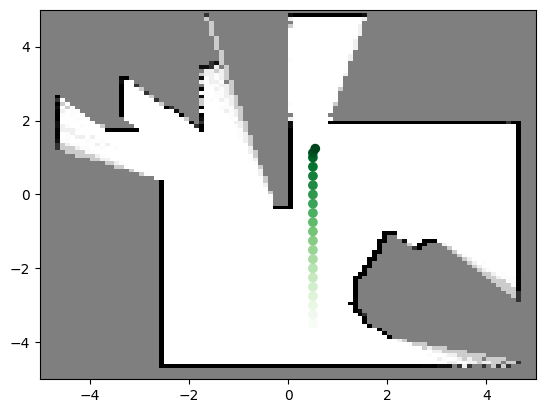

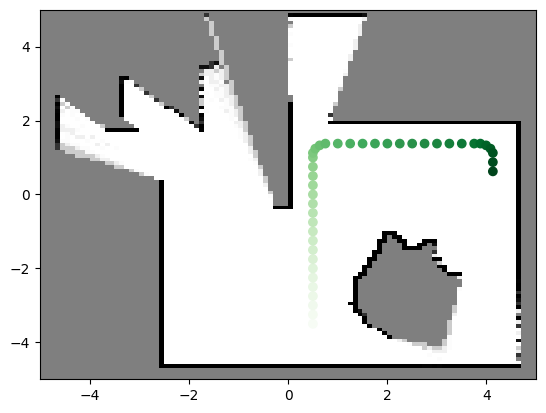

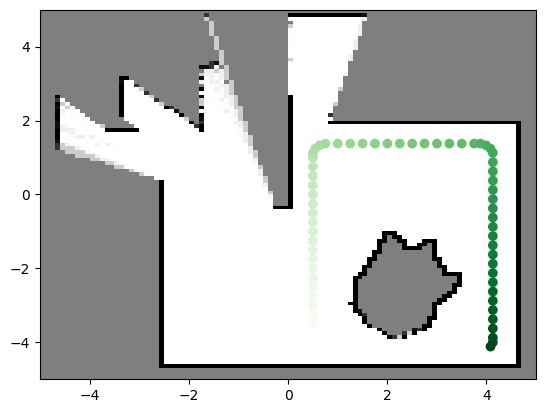

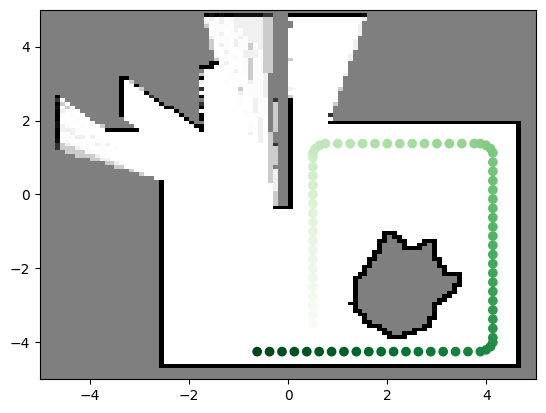

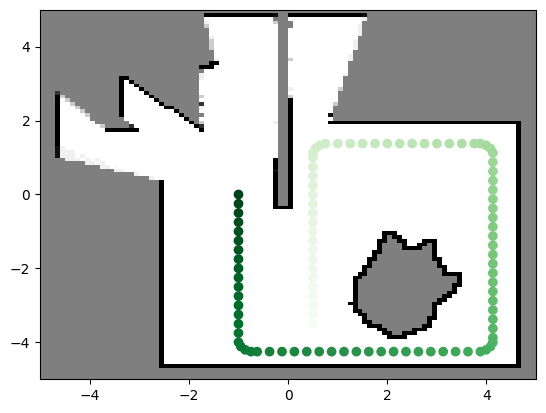

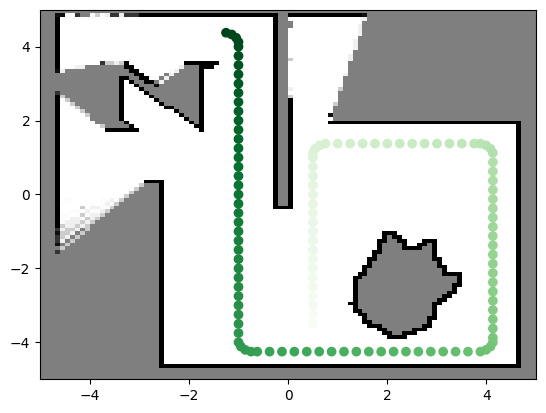

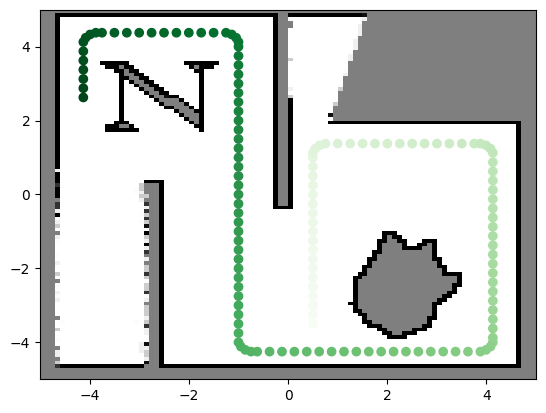

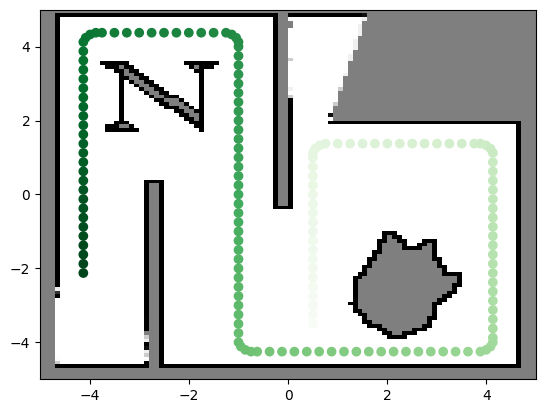

In [22]:
# Initialize the environment (and set random seed so any randomness is repeatable)
env = gymnasium.make("gym_neu_racing/NEUMapping-v0")
np.random.seed(0)

# Tell the environment to use a wheel speed sensor (for odometry estimation), a
# lidar sensor (just for mapping), and make the true state
# available in obs (just for debugging)
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "lidar": sensor_models.Lidar2D(
        env.unwrapped.map,
        num_beams=360,
        angle_limits=np.array([-np.pi, np.pi]),
    ),
}

# Set up the simulation parameters
env.unwrapped.dt = 0.25
env.unwrapped.motion_model = motion_models.Unicycle()
initial_state = np.array([0.5, -3.5, np.pi / 2])
control_policy = OpenLoopPolicy()

# Reset the environment and get the first observation (state + lidar + wheel speeds)
obs, _ = env.reset()
env.unwrapped.state = initial_state
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

states = []
lidar_measurements = []

for step_num, t in enumerate(np.arange(0, 40, env.unwrapped.dt)):

    # calculate which action to implement on this timestep
    action_twist = control_policy.get_action(t)

    # Extract sensor data
    states.append(obs["state"])
    lidar_measurements.append(obs["lidar"])

    # Update the factor graph with this step's odometry info & re-solve
    estimates = {
        "pose_means": [gtsam.Pose2(pose[0], pose[1], pose[2]) for pose in states]
    }

    # Update the map with latest pose estimates & lidar scans
    if step_num % 20 == 0 and step_num > 0:
        compute_map(estimates["pose_means"], lidar_measurements, initial_state=None, pause=0.1, map_xwidth=10, map_ywidth=10)

    # Advance the simulator (i.e., robot moves and makes a new measurement)
    obs, _, _, _, _ = env.step(action_twist)

# Calculate a final map after the full trajectory
compute_map(estimates["pose_means"], lidar_measurements, initial_state=None, pause=False, show=True, map_xwidth=10, map_ywidth=10)

## 2b) Factor Graphs with Odometry from Motion Model

To begin, in this part you will create an `OdometryFactorGraph` that estimates the robot's pose over time, using control inputs and the `Unicycle` motion model. Meanwhile, the simulator itself (the "true robot") will be reporting its left and right wheel speeds that have been corrupted with noise. By defining a factor graph and solving the corresponding inference problem, you will obtain an estimate of the pose (i.e., its mean and covariance at each timestep). Your `step` method will return this estimate, and we provide some functions for plotting this and generating a map based on that estimate.

To set up your factor graph, you'll need to implement a few methods:
- `add_prior_pose_factor`: add a `PriorFactorPose2` at the origin to encode where the robot starts
- `add_motion_model_factor`: add a `BetweenFactorPose2` with the relative transformation between the current pose and previous pose
- `solve`: find the optimal estimates for each variable node ($\Theta_j$ in lecture) using the cost function that your factor graph defines

We implemented `step` for you, but you are welcome to modify that as well.

**Deliverables**:
- Implement the three methods listed above
- Generate a plot of your robot's estimated pose over time and the rendered map, for a few different values of the wheel speed sensor's noise variance. To calibrate your expectations, it should look perfect with `0`, it should look nearly perfect with `0.1**2`, you should start to see some drift with `0.2**2`, and it should be quite bad with `0.5**2` or higher

In [ ]:
class OdometryFactorGraph:
    def __init__(self, dt=0.1, motion_model=motion_models.Unicycle()):

        self.dt = dt
        self.motion_model = motion_model

        self.prior_noise = gtsam.noiseModel.Diagonal.Sigmas(
            np.array([0.01, 0.01, 0.01])
        )
        self.odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(
            1e-2 * np.ones(3)
        )

        self.graph = gtsam.NonlinearFactorGraph()
        self.initial_estimate = gtsam.Values()

        self.current_state_index = 0
        self.poses = []

    def add_motion_model_factor(self, control: np.ndarray) -> None:
        # Compute pose at current timestep expressed in frame at previous timestep
        # using self.motion_model.step
        # Create a BetweenFactorPose2 between self.poses[-2] and self.poses[-1]
        # Add that factor to self.graph
        # Add initial estimate for self.poses[-1]
        
        prev_pose = self.initial_estimate.atPose2(self.poses[-2])  # Get last known pose
        propogated_pose = self.motion_model.step(np.array([prev_pose.x(), prev_pose.y(), prev_pose.theta()]), control, self.dt)
        new_pose = gtsam.Pose2(propogated_pose[0], propogated_pose[1], propogated_pose[2])
        relative_pose = prev_pose.inverse().compose(new_pose)
        self.graph.add(gtsam.BetweenFactorPose2(self.poses[-2], self.poses[-1], relative_pose, self.odometry_noise))
        self.initial_estimate.insert(self.poses[-1], new_pose)

        # raise NotImplementedError

    def add_prior_pose_factor(self) -> None:
        # Create a PriorFactorPose2 for self.poses[-1]
        # Add that factor to self.graph
        # Don't forget to add an initial (global) estimate for that pose!
        intial_pose = gtsam.Pose2(0, 0, 0)
        self.graph.add(gtsam.PriorFactorPose2(self.poses[-1], intial_pose, self.prior_noise))
        self.initial_estimate.insert(self.poses[-1], intial_pose)

        # raise NotImplementedError

    def solve(self):
        # Optimize current self.graph using self.initial_estimate and params
        # Return the result (from optimizer.optimize()) and corresponding
        # marginals (from gtsam.Marginals(self.graph, result))

        # params = gtsam.LevenbergMarquardtParams()
        # optimizer = gtsam.LevenbergMarquardtOptimizer(self.graph, self.initial_estimate, params)
        optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial_estimate)
        result = optimizer.optimize()
        marginals = gtsam.Marginals(self.graph, result)
        # raise NotImplementedError

        return result, marginals

    def step(self, obs: dict, action: np.ndarray) -> dict:
        # Each time step is called, add nodes & factors to self.graph and solve
        # for the MLE estimate.

        # To make it clear what each variable means, you can use
        # gtsam.symbol_shorthand.X(1), ...X(2), ... for poses in GTSAM.

        # Add new pose variable to factor graph, along with an initial estimate
        self.poses.append(gtsam.symbol_shorthand.X(self.current_state_index))

        # Add factors between poses (otherwise you'd just have a graph of variable nodes)
        if self.current_state_index == 0:
            # on the first step, just add a prior pose (no relative motion yet)
            self.add_prior_pose_factor()
        else:
            # add factor for relative motion between current and last pose
            self.add_motion_model_factor(action)

        # Solve for the MLE estimate of each variable in self.graph
        result, marginals = self.solve()

        # Store the Pose2 and Covariance results in estimates
        # Update the initial estimates for future calls to this method
        pose_means = []
        pose_covariances = []
        for var in self.poses:
            pose = result.atPose2(var)
            pose_means.append(pose)
            pose_covariances.append(marginals.marginalCovariance(var))
            self.initial_estimate.update(var, pose)
        estimates = {
            'pose_means': pose_means,
            'pose_covariances': pose_covariances,
        }

        self.current_state_index += 1
        return estimates

Here's a code block to see how well your `OdometryFactorGraph` is doing.

You may notice that we set the `map_xwidth` and `map_ywidth` to be a little bigger than the true map (which was 10x10), so that if your pose estimates are incorrect, the scans should still get rendered without breaking the mapper's boundaries. Perhaps next year we will create a better `Mapper` whose size is not pre-defined...

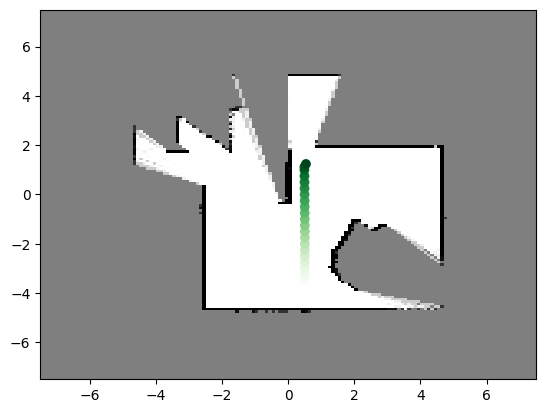

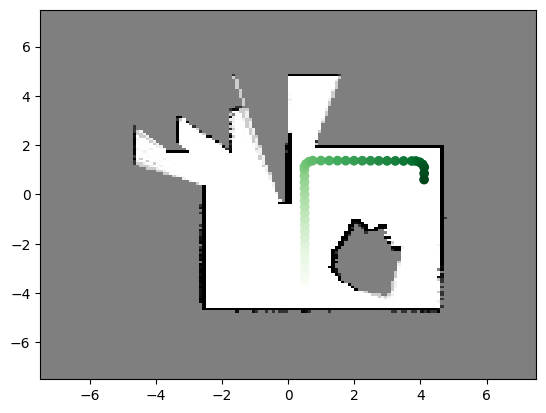

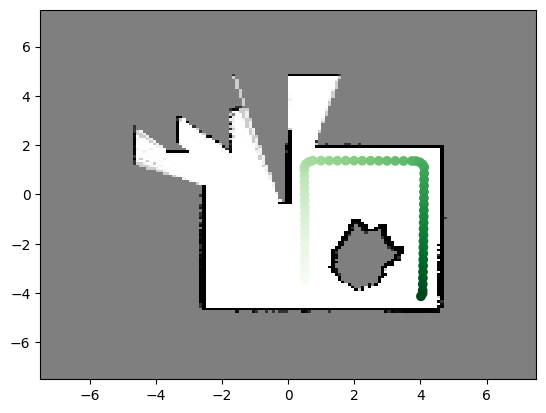

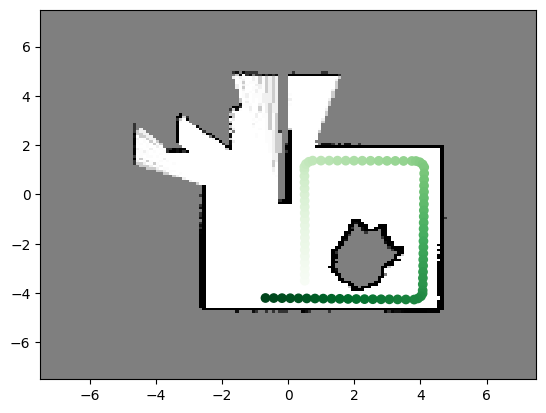

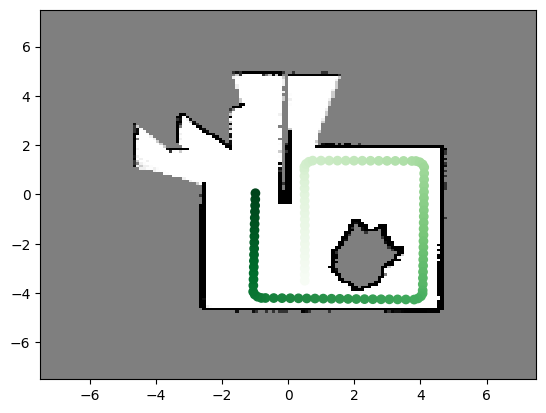

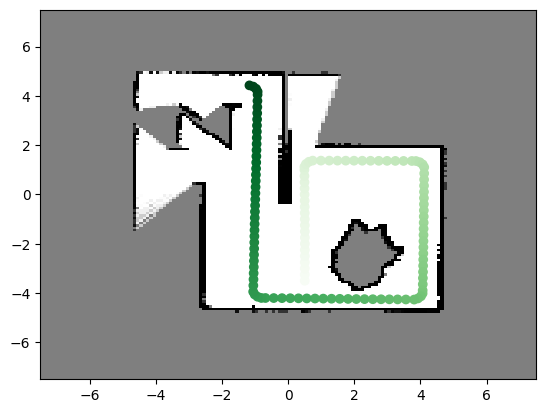

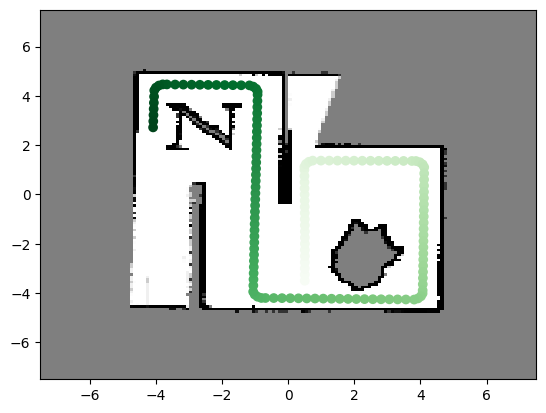

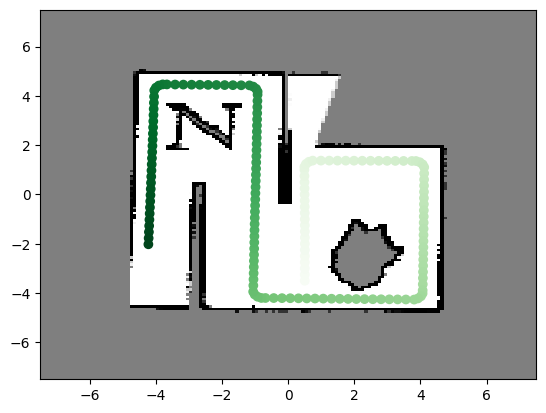

In [38]:
# Initialize the environment (and set random seed so any randomness is repeatable)
env = gymnasium.make("gym_neu_racing/NEUMapping-v0")
np.random.seed(0)

# Tell the environment to use a wheel speed sensor (for odometry estimation), a
# lidar sensor (just for mapping), and make the true state
# available in obs (just for debugging)

# You can change the variance arg in env.unwrapped.sensor_models["wheel_speeds"]
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "wheel_speeds": sensor_models.NoisyWheelSpeedSensor(variance=0.1**2),
    "lidar": sensor_models.Lidar2D(
        env.unwrapped.map,
        num_beams=360,
        angle_limits=np.array([-np.pi, np.pi]),
    ),
}

# Set up the simulation parameters
env.unwrapped.dt = 0.25
env.unwrapped.motion_model = motion_models.Unicycle()
initial_state = np.array([0.5, -3.5, np.pi / 2])
control_policy = OpenLoopPolicy()

# Reset the environment and get the first observation (state + lidar + wheel speeds)
obs, _ = env.reset()
env.unwrapped.state = initial_state
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

# Instantiate your OdometryFactorGraph class, which will be queried as the robot moves
odometry = OdometryFactorGraph(dt=env.unwrapped.dt)

states = []
lidar_measurements = []

for step_num, t in enumerate(np.arange(0, 40, env.unwrapped.dt)):

    # calculate which action to implement on this timestep
    action_twist = control_policy.get_action(t)

    # Extract sensor data
    states.append(obs["state"])
    lidar_measurements.append(obs["lidar"])
    measured_twist = wheel_speed_to_twist(obs["wheel_speeds"])

    # Update the factor graph with this step's odometry info & re-solve
    estimates = odometry.step(obs, measured_twist)

    # Update the map with latest pose estimates & lidar scans
    if step_num % 20 == 0 and step_num > 0:
        compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=0.1, map_xwidth=15, map_ywidth=15)

    # Advance the simulator (i.e., robot moves and makes a new measurement)
    obs, _, _, _, _ = env.step(action_twist)

# Calculate a final map after the full trajectory
compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=False, show=True, map_xwidth=15, map_ywidth=15)

## 2c) Additionally incorporate relative pose estimates between timesteps using ICP

The previous part was just a warmup to get you familiar with GTSAM and working with factor graphs in code.

In this part, you will replace the `BetweenPose` factors in your factor graph to be based on ICP, as opposed to propagated wheel speed measurements. But, don't throw out those wheel speeds yet! You need a good initial guess for ICP to have a chance of working well, and your propagated wheel speeds can provide this initial guess.

There is a tradeoff here. On the one hand, the propagated midly noisy wheel speed measurements don't lead to a very good estimate *globally* (lots of drift), but the resulting pose estimates are at least reasonably consistent *locally*. On the other hand, ICP can either help a lot or totally destory the pose estimates. When ICP converges to a good answer, the improvements can greatly reduce the drift. But, it is not always obvious why, when, or what to do if ICP does converge to a bad answer, and adding a bad `BetweenPose` factor to your factor graph is likely to lead to completely wild answers.

But, with some tuning, you should be able to get the beginnings of a decent map by the end of this part of the assignment!

In case you're curious, this is still not technically SLAM, but rather a fancier odometry method than before with a mapping algorithm that is running based on that result.

**Deliverables**:
- Implement the `LidarWheelSpeedOdometry` class by completing `add_lidar_motion_model_factor`, i.e., given the current and previous lidar measurements and measured twist, add a `BetweenPose` factor between the previous and current pose, based on the output of ICP
- Generate the same type of plots as in the previous part, for various levels of noise in the wheel speed sensor. You can keep using the perfect lidar sensor.

In [159]:
class LidarWheelSpeedOdometry(OdometryFactorGraph):
    def __init__(self, dt=0.1, motion_model=motion_models.Unicycle()):

        # LidarWheelSpeedOdometry will be a child class of OdometryFactorGraph from above,
        # and will just add some methods for adding landmark nodes/factors
        # to supplement the nodes/factors from the motion model
        super().__init__(dt=dt, motion_model=motion_model)

        self.measurement_noise = gtsam.noiseModel.Diagonal.Sigmas(
            np.array([0.5, 0.5])
        )

        self.sensor_msgs = []

    # Function to change the lidar format from dictionary to expected format
    def lidar_obs_to_hit_pts(self, lidar_measurement: dict[str, np.ndarray]):
        ranges = lidar_measurement["ranges"]  # Distances
        angles = lidar_measurement["angles"]  # Corresponding angles

        # Convert to Cartesian coordinates
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)

        points = np.column_stack((x, y))

        return points

    def add_lidar_motion_model_factor(
        self, current_lidar_measurement: dict[str, np.ndarray], prev_lidar_measurement: dict[str, np.ndarray], control: np.ndarray
    ) -> None:
        # Use self.motion_model to get an initial guess on the transformation
        # btwn current and prev poses
        # Run ICP btwn current and prev lidar measurements (or vice versa)
        # Add BetweenFactor based on ICP result
        # Add initial estimate for self.poses[-2]
        prev_pose = self.initial_estimate.atPose2(self.poses[-2])
        propogated_pose = self.motion_model.step(np.array([prev_pose.x(), prev_pose.y(), prev_pose.theta()]), control, self.dt)
        current_pose = gtsam.Pose2(propogated_pose[0], propogated_pose[1], propogated_pose[2])
        # print(f"Index: {self.current_state_index}")
        # ICP
        xd = current_pose.x() - prev_pose.x()
        yd = current_pose.y() - prev_pose.y()
        thetad = current_pose.theta() - prev_pose.theta()
        
        t0 = np.array([xd, yd])
        r0 = np.array([[np.cos(thetad), -np.sin(thetad)], [np.sin(thetad), np.cos(thetad)]])
        prev_lidar = self.lidar_obs_to_hit_pts(prev_lidar_measurement)
        current_lidar = self.lidar_obs_to_hit_pts(current_lidar_measurement)

        registrar = ICP(d_max=0.5, num_iterations=100)
        t, Rotate = registrar.run(current_lidar, prev_lidar, t0, r0, plot_every=1, show=False)

        relative_pose = gtsam.Pose2(t[0], t[1], np.arctan2(Rotate[1, 0], Rotate[0, 0]))
        self.graph.add(gtsam.BetweenFactorPose2(self.poses[-2], self.poses[-1], relative_pose, self.odometry_noise))
        self.initial_estimate.insert(self.poses[-1], relative_pose)
        # raise NotImplementedError

    def step(self, obs: dict, action: np.ndarray) -> dict:
        # Each time step is called, add nodes & factors to self.graph and solve
        # for the MLE estimate.

        # Keep track of history of sensor msgs (we'll only use the most recent
        # one for this part, but later we'll also use this for loop closures)
        self.sensor_msgs.append(obs)

        # To make it clear what each variable means, you can use
        # gtsam.symbol_shorthand.X(1), ...X(2), ... for states in GTSAM.

        # Add new pose variable to factor graph, along with an initial estimate
        self.poses.append(gtsam.symbol_shorthand.X(self.current_state_index))

        # Add factors between poses (otherwise you'd just have a graph of variable nodes)
        if self.current_state_index == 0:
            # on the first step, just add a prior pose (no relative motion yet)
            self.add_prior_pose_factor()
        else:
            # add factor for relative motion between current and last pose
            self.add_lidar_motion_model_factor(
                self.sensor_msgs[-1]["lidar"],
                self.sensor_msgs[-2]["lidar"],
                action,
            )

        # Solve for the MLE estimate of each variable in self.graph
        result, marginals = self.solve()

        # Store the Pose2 and Covariance results in estimates
        # Update the initial estimates for future calls to this method
        pose_means = []
        pose_covariances = []
        for var in self.poses:
            pose = result.atPose2(var)
            pose_means.append(pose)
            pose_covariances.append(marginals.marginalCovariance(var))
            self.initial_estimate.update(var, pose)
        estimates = {
            'pose_means': pose_means,
            'pose_covariances': pose_covariances,
        }

        self.current_state_index += 1
        return estimates

You can check how much this helped your pose estimates and resulting map with this code block:

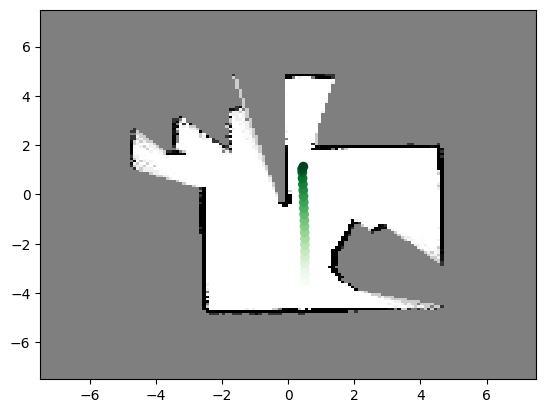

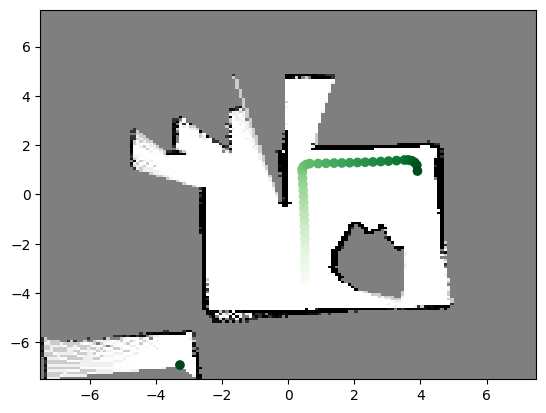

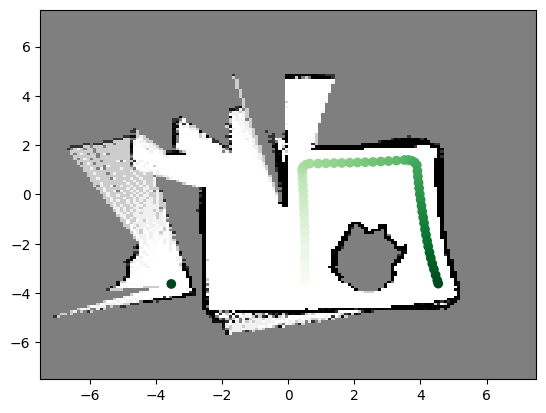

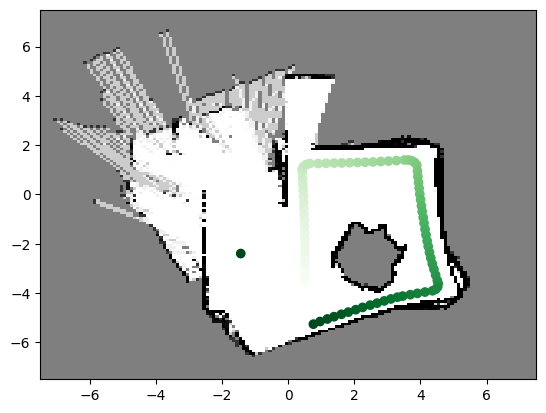

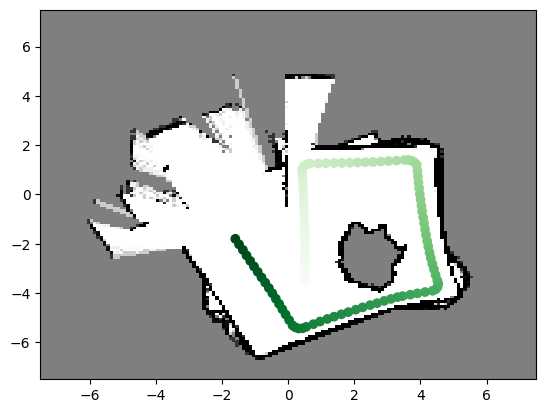

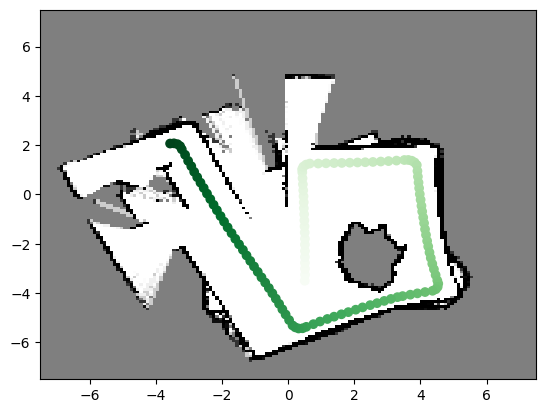

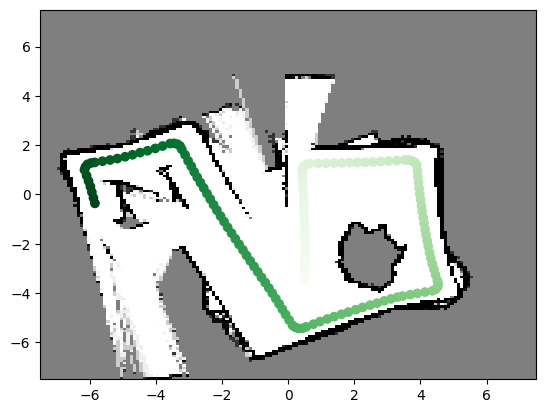

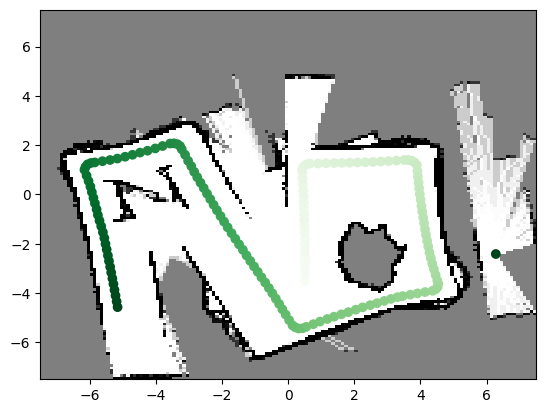

In [160]:
# Initialize the environment (and set random seed so any randomness is repeatable)
env = gymnasium.make("gym_neu_racing/NEUMapping-v0")
np.random.seed(0)

# Tell the environment to use a wheel speed and Lidar2D sensor (and make the true state available in obs, just for debugging)
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "wheel_speeds": sensor_models.NoisyWheelSpeedSensor(variance=0.1**2),
    "lidar": sensor_models.Lidar2D(
        env.unwrapped.map,
        num_beams=360,
        angle_limits=np.array([-np.pi, np.pi]),
    ),
}

# Set up the simulation parameters
env.unwrapped.dt = 0.25
env.unwrapped.motion_model = motion_models.Unicycle()
initial_state = np.array([0.5, -3.5, np.pi / 2])
control_policy = OpenLoopPolicy()

# Reset the environment and get the first observation (state + lidar + wheel speeds)
obs, _ = env.reset()
env.unwrapped.state = initial_state
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

# Instantiate your LidarWheelSpeedOdometry class, which will be queried as the
# robot moves
lidar_wheel_speed_odometry = LidarWheelSpeedOdometry(dt=env.unwrapped.dt)

states = []
lidar_measurements = []

for step_num, t in enumerate(np.arange(0, 40, env.unwrapped.dt)):

    # calculate which action to implement on this timestep
    action_twist = control_policy.get_action(t)

    # Extract sensor data
    states.append(obs["state"])
    lidar_measurements.append(obs["lidar"])
    measured_twist = wheel_speed_to_twist(obs["wheel_speeds"])

    # Update the factor graph with this step's odometry info & re-solve
    estimates = lidar_wheel_speed_odometry.step(obs, measured_twist)

    # Update the map with latest pose estimates & lidar scans
    if step_num % 20 == 0 and step_num > 0:
        compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=0.1, map_xwidth=15, map_ywidth=15)

    # Advance the simulator (i.e., robot moves and makes a new measurement)
    obs, _, _, _, _ = env.step(action_twist)

# Calculate a final map after the full trajectory
compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=False, show=True, map_xwidth=15, map_ywidth=15)

## 2d) Additionally add loop closures using ICP

The relative pose factors based on ICP should have helped a bit. But, the map probably still looks a little smeared out, because there is drift over time.

To reduce this drift, you will now add some loop closures. By loop closure, we mean an additional `BetweenPose` factor that links two poses that are *not* directly subsequent in time. You can calculate the transformation parameter in this factor by running ICP on the lidar pointclouds at the two non-subsequent timesteps. Again, you'll need an initial guess, but the previous parts of the assignment have given you a few options for that. It's up to you what to use for the initial guess.

Deciding when to add loop closures can get pretty complicated, so in this assignment you can simply hard-code some instances of when to add a loop closure (e.g., by defining pairs of timesteps or a rate at which to perform a loop closure). Furthermore, the term "loop closure" suggests the robot has left the area and come back, but you are encouraged to add "loop closures" more often to see if they help your estimator's performance.

Again, there are some important tradeoffs here. Not having any loop closures will limit the global consistency. Whereas adding too many loop closures leads to a less sparse factor graph, which leads to higher solve times. Furthermore, just like adding a bad `BetweenPose` factor could cause issues in the previous part, the same thing can happen here. For example, if there's not enough overlap between the pointclouds at two timesteps, ICP will return a garbage transformation and the resulting bad loop closure can destroy your pose estimates. People usually err on the side of *not* adding risky loop closures for this reason!

Now that we have a stored history of measurements to correct drift, there is some notion of a map, so there is an argument for calling this SLAM. It is not "classical" SLAM in that we are not explicitly optimizing over the map/landmarks, but the inclusion of loop closures / place recognition is one way people distinguish between Odometry and SLAM.

**Deliverables**:
- Implement `LidarSLAM`, which inherits from `LidarWheelSpeedOdometry`, by completing the `add_lidar_loop_closure_factor` method, which takes in the lidar measurements at two timesteps, the corresponding GTSAM pose variables, and an initial guess of the relative pose between those two timesteps. We provide some basic logic in `step` to add a loop closure at fixed frequencies, but you are encouraged to change this!
- Provide some plots that show what happens for various decisions about when to add loop closures. Ideally for one or more of these plots, you get a nearly perfect map and pose estimates!


In [188]:
class LidarSLAM(LidarWheelSpeedOdometry):
    def __init__(self, dt=0.1, motion_model=motion_models.Unicycle()):

        # LidarSLAM will be a child class of LidarWheelSpeedOdometry from above,
        # and will just add some methods for adding loop closure factors
        # to supplement the nodes/factors from the motion model and ICP between
        # successive timesteps
        super().__init__(dt=dt, motion_model=motion_model)

    # Function to change the lidar format from dictionary to expected format
    def lidar_obs_to_hit_pts(self, lidar_measurement: dict[str, np.ndarray]):
        ranges = lidar_measurement["ranges"]  # Distances
        angles = lidar_measurement["angles"]  # Corresponding angles

        # Convert to Cartesian coordinates
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)

        points = np.column_stack((x, y))

        return points

    def add_lidar_loop_closure_factor(
        self,
        current_lidar_measurement: dict[str, np.ndarray],
        prev_lidar_measurement: dict[str, np.ndarray],
        relative_pose_initial_guess: gtsam.Pose2,
        current_pose_var, # type: gtsam.Key
        prev_pose_var, # type: gtsam.Key
    ) -> None:

        # Run ICP btwn current and prev lidar measurements, using relative_pose
        # _initial_guess as initial guess
        # Add BetweenFactor based on that result
        prev_lidar = self.lidar_obs_to_hit_pts(prev_lidar_measurement)
        current_lidar = self.lidar_obs_to_hit_pts(current_lidar_measurement)

        xd, yd = relative_pose_initial_guess.x(), relative_pose_initial_guess.y()
        thetad = relative_pose_initial_guess.theta()

        t0 = np.array([xd, yd])
        r0 = np.array([[np.cos(thetad), -np.sin(thetad)], [np.sin(thetad), np.cos(thetad)]])

        registrar = ICP(d_max=0.5, num_iterations=100)
        t, Rotate = registrar.run(current_lidar, prev_lidar, t0, r0, plot_every=1, show=False)

        relative_pose = gtsam.Pose2(t[0], t[1], np.arctan2(Rotate[1, 0], Rotate[0, 0]))
        self.graph.add(gtsam.BetweenFactorPose2(prev_pose_var, current_pose_var, relative_pose, self.odometry_noise))
        # self.initial_estimate.insert(current_pose_var, relative_pose)
        

        # raise NotImplementedError

    def step(self, obs: dict, action: np.ndarray) -> dict:

        # First do whatever LidarWheelSpeedOdometry would have done (add a node,
        # add a prior, add an ICP factor btwn nodes, etc.). If we don't have
        # any loop closures to add this iteration, we'll just return this.
        estimates = super().step(obs, action)

        # super().step incremeneted the time index, so temporarily decrease it
        self.current_state_index -= 1

        # Now let's add loop closure(s) if we meet certain conditions

        # ref_point = np.array([0.25, 0])
        # current_point = np.array([current_pose_var.x(), current_pose_var.y()])
        # dist = np.linalg.norm(ref_point - current_point)
        num_steps = 79

        if self.current_state_index == num_steps:

            # Lidar Measurements
            past_index = self.current_state_index - num_steps # is it last one or prevousliy ever seeen
            prev_pose_var = self.poses[past_index]
            current_pose_var = self.poses[self.current_state_index]
            # print(f'current pose = {current_pose_var}, prev pose = {prev_pose_var}')

            prev_lidar_measurement = self.sensor_msgs[past_index]["lidar"]
            current_lidar_measurement = obs["lidar"]

            # Get initial guess for relative transformation
            prev_pose = self.initial_estimate.atPose2(prev_pose_var)
            current_pose = self.initial_estimate.atPose2(current_pose_var)
            relative_pose_guess = prev_pose.inverse().compose(current_pose)

            # Add loop closure factor
            self.add_lidar_loop_closure_factor(
                current_lidar_measurement, 
                prev_lidar_measurement,
                relative_pose_guess, 
                current_pose_var, 
                prev_pose_var)
        # raise NotImplementedError

        # increase the time index again, now that we're done with this iteration
        self.current_state_index += 1
        return estimates

You can evaluate your new `LidarSLAM` code just like before:

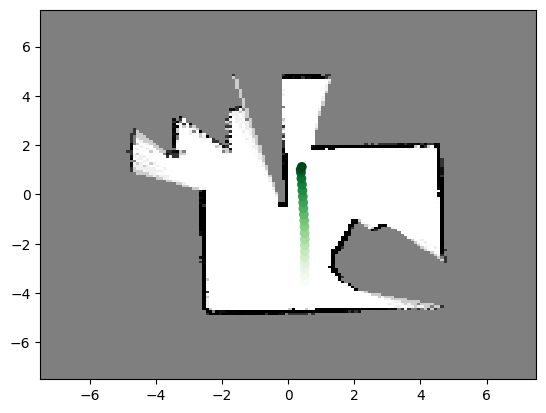

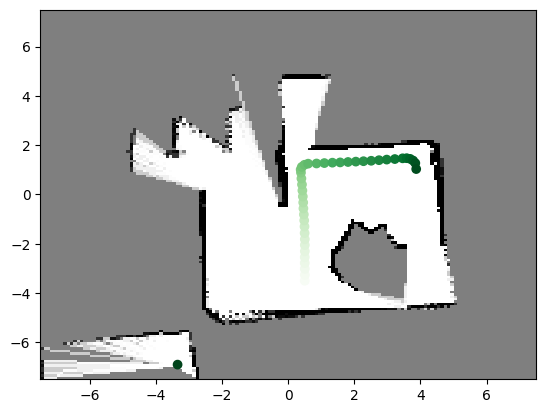

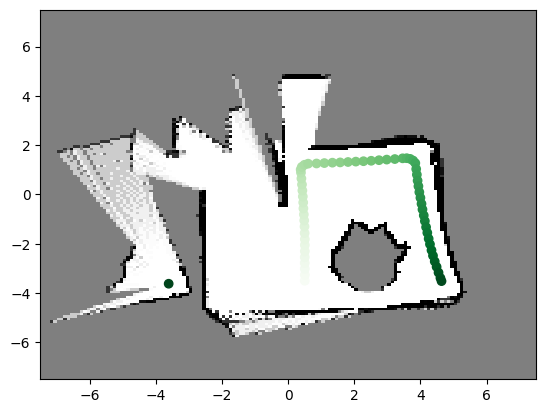

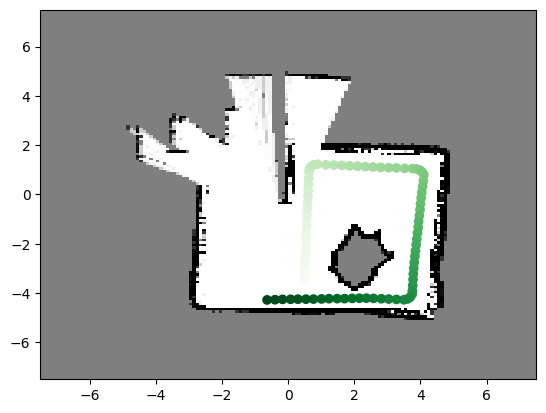

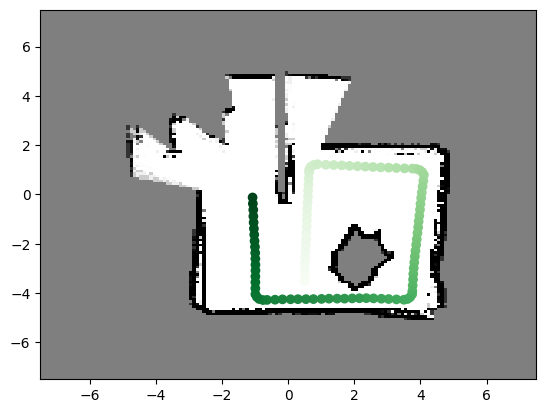

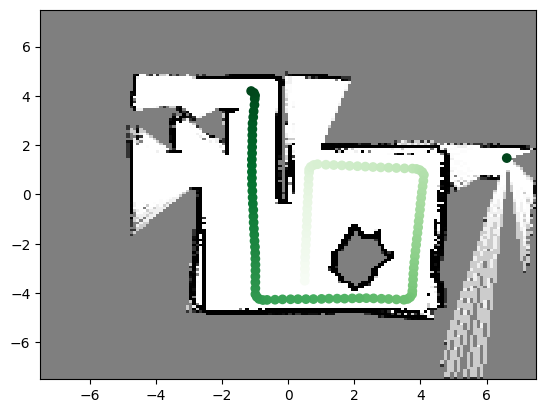

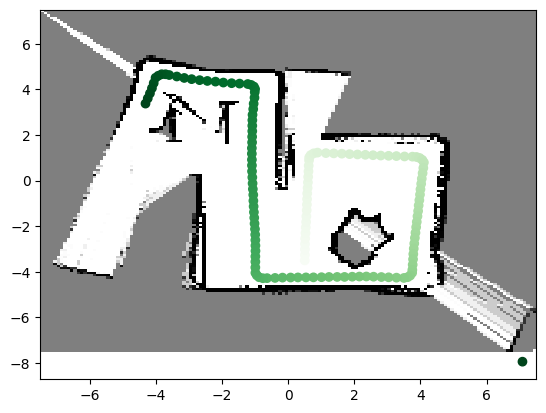

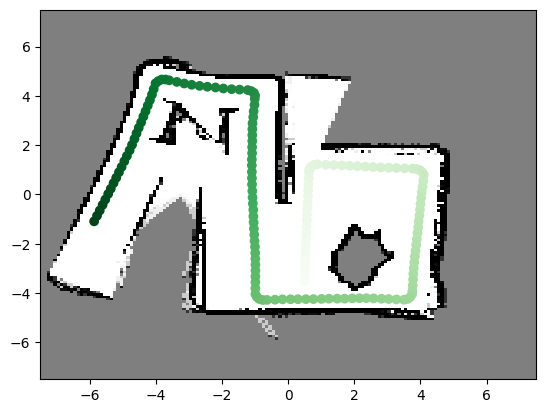

In [189]:
# Initialize the environment (and set random seed so any randomness is repeatable)
env = gymnasium.make("gym_neu_racing/NEUMapping-v0")
np.random.seed(0)

# Tell the environment to use a wheel speed and Lidar2D sensor (and make the true state available in obs, just for debugging)
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "wheel_speeds": sensor_models.NoisyWheelSpeedSensor(variance=0.5**2),
    "lidar": sensor_models.Lidar2D(
        env.unwrapped.map,
        num_beams=360,
        angle_limits=np.array([-np.pi, np.pi]),
    ),
}

# Set up the simulation parameters
env.unwrapped.dt = 0.25
env.unwrapped.motion_model = motion_models.Unicycle()
initial_state = np.array([0.5, -3.5, np.pi / 2])
control_policy = OpenLoopPolicy()

# Reset the environment and get the first observation (state + lidar + wheel speeds)
obs, _ = env.reset()
env.unwrapped.state = initial_state
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

# Instantiate your LidarSLAM class, which will be queried as the robot moves
lidar_slam = LidarSLAM(dt=env.unwrapped.dt)

states = []
lidar_measurements = []

for step_num, t in enumerate(np.arange(0, 40, env.unwrapped.dt)):

    # calculate which action to implement on this timestep
    action_twist = control_policy.get_action(t)

    # Extract sensor data
    states.append(obs["state"])
    lidar_measurements.append(obs["lidar"])
    measured_twist = wheel_speed_to_twist(obs["wheel_speeds"])

    # Update the factor graph with this step's odometry info & re-solve
    estimates = lidar_slam.step(obs, measured_twist)

    # Update the map with latest pose estimates & lidar scans
    if step_num % 20 == 0 and step_num > 0:
        compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=0.1, map_xwidth=15, map_ywidth=15)

    # Advance the simulator (i.e., robot moves and makes a new measurement)
    obs, _, _, _, _ = env.step(action_twist)

# Calculate a final map after the full trajectory
compute_map(estimates["pose_means"], lidar_measurements, initial_state=initial_state, pause=False, show=True, map_xwidth=15, map_ywidth=15)

## 2e) [Extra Credit]: Replace the control policy to explore the map more efficiently

So far, this assignment used a hard-coded, open-loop control policy to define the robot's actions at each timestep. We designed this path so the robot would get reasonable viewpoints of the map and have some opportunities for loop closures, but you likely noticed that one of the corners of the map was never explored.

To get extra credit, you can implement an exploration strategy that selects actions based on the robot's current belief over its pose and the map. The objective is to reduce the uncertainty in both of these as quickly as possible, ultimately providing a complete map and accurate estimate of the robot's trajectory, using as few timesteps as possible.

Since this is extra credit, we won't give more template code and will encourage you to try things out for yourself!

All done!

# Appendix: [Purely Informational, not part of the assignment] Generate Pointclouds from Images for fun with ICP 😀

If you want to generate other pointclouds to show off your ICP implementation, here's some simple code that we used to get the Northeastern logo, transform it, and save the results:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the image
image = cv2.imread("northeastern_logo.png")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold (you may need to adjust the threshold value)
_, binary_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Extract coordinates of non-background (non-zero) pixels
points = np.column_stack(np.where(binary_image == 255))

points = np.vstack([points[:, 1], points[:, 0]]).T

points[:, 1] = image.shape[1] - points[:, 1]

# points now contains the (x, y) coordinates of the non-background pixels
print(points)

In [ ]:
# Plot the points
plt.scatter(points[:, 0], points[:, 1], color='black', s=1)  # Scatter with x,y swapped for proper display
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
theta = 0.9
t = np.array([500, -70])
T = np.array([[np.cos(theta), -np.sin(theta), t[0]], [np.sin(theta), np.cos(theta), t[1]], [0, 0, 1]])

points_transformed = (T@np.hstack([points, np.ones((points.shape[0], 1))]).T).T

plt.scatter(points[:, 0], points[:, 1], color='black', s=1)  # Scatter with x,y swapped for proper display
plt.scatter(points_transformed[:, 0], points_transformed[:, 1], color='red', s=1)  # Scatter with x,y swapped for proper display
plt.gca().set_aspect('equal')
plt.show()


In [ ]:
np.savetxt('logo_pcl2dX.txt', points_transformed)
np.savetxt('logo_pcl2dY.txt', points)